## CC219-Aplicaciones de Data Science ##

## <h3 align="center"><b>TP:</b> NLP - Hotel reviews </h3>
<h3 align="center">2025-1</h3>

FUENTE: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/data

##### Importaciones

In [1]:
# ==============================================================================
# SECCIÓN 1: INSTALACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# ==============================================================================
#!pip install transformers torch pandas scikit-learn seaborn matplotlib wordcloud shap kagglehub ipywidgets


In [2]:
# ==============================================================================
# SECCIÓN 2: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import shap
import kagglehub
import os
import zipfile
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Descargando dataset desde Kaggle Hub...

Archivo CSV cargado exitosamente desde Kaggle Hub.


/tmp/ipython-input-3-777801079.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


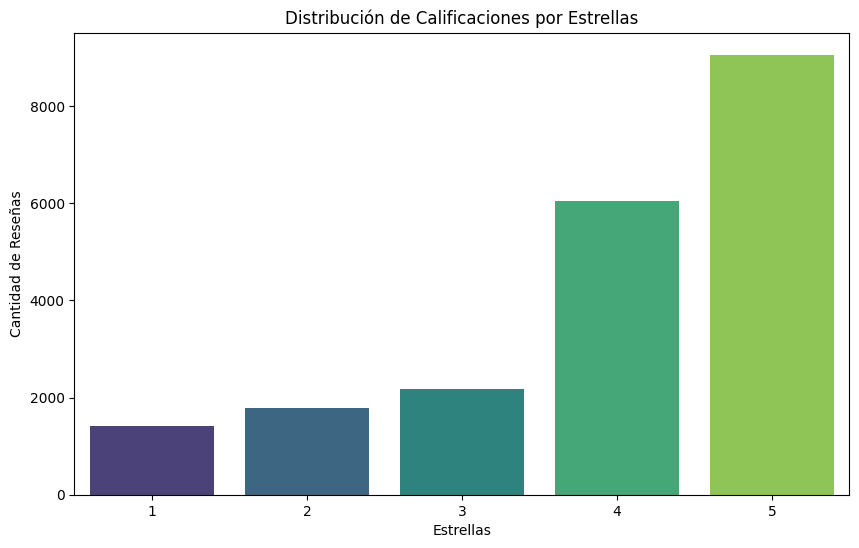

In [3]:
# ==============================================================================
# SECCIÓN 3: CARGA Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==============================================================================
print("Descargando dataset desde Kaggle Hub...")
try:
    dataset_path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")
    csv_filename = 'tripadvisor_hotel_reviews.csv'
    csv_file_path = os.path.join(dataset_path, csv_filename)
    df = pd.read_csv(csv_file_path)
    print("\nArchivo CSV cargado exitosamente desde Kaggle Hub.")
except Exception as e:
    print(f"\nError al descargar o cargar el dataset desde Kaggle Hub: {e}")
    exit()

# --- CAMBIO: Preparación de etiquetas para clasificación multiclase ---
# El objetivo es la columna 'Rating'. Los modelos necesitan etiquetas que empiecen en 0.
# Creamos una columna 'label' donde Rating 1 -> 0, Rating 2 -> 1, ..., Rating 5 -> 4.
df['label'] = df['Rating'] - 1

# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribución de Calificaciones por Estrellas')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Reseñas')
plt.show()

In [4]:
# ==============================================================================
# SECCIÓN 4: PREPROCESAMIENTO Y CREACIÓN DEL DATASET PARA BERT
# ==============================================================================
# --- CAMBIO: El objetivo (y) ahora es la columna 'label' ---
MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

X_train, X_test, y_train, y_test = train_test_split(
    df['Review'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

class HotelReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews.iloc[item])
        label = self.labels.iloc[item]
        encoding = self.tokenizer.encode_plus(
            review, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            return_attention_mask=True, return_tensors='pt', truncation=True
        )
        return {
            'review_text': review, 'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df_reviews, df_labels, tokenizer, max_len, batch_size):
    ds = HotelReviewDataset(reviews=df_reviews, labels=df_labels, tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

MAX_LEN = 160
BATCH_SIZE = 16
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [5]:
# ==============================================================================
# SECCIÓN 5: ENTRENAMIENTO DEL MODELO BETO (MULTICLASE)
# ==============================================================================
# --- CAMBIO: num_labels ahora es 5 ---
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model = model.to(device)

# --- Manejo de Desbalance de Clases (aún más importante en multiclase) ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses, correct_predictions = [], 0
    for d in data_loader:
        input_ids, attention_mask, labels = d["input_ids"].to(device), d["attention_mask"].to(device), d["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step(), scheduler.step(), optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses, correct_predictions = [], 0
    with torch.no_grad():
        for d in data_loader:
            input_ids, attention_mask, labels = d["input_ids"].to(device), d["attention_mask"].to(device), d["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

print("\n--- Iniciando Entrenamiento (Tarea: Predecir 1-5 Estrellas) ---")
for epoch in range(EPOCHS):
    print(f'Época {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(X_train))
    print(f'Pérdida (train): {train_loss:.4f} - Precisión (train): {train_acc:.4f}')
    val_acc, val_loss = eval_model(model, test_data_loader, loss_fn, device, len(X_test))
    print(f'Pérdida (val): {val_loss:.4f} - Precisión (val): {val_acc:.4f}')
print("\n--- Entrenamiento Completado ---")


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


--- Iniciando Entrenamiento (Tarea: Predecir 1-5 Estrellas) ---
Época 1/3
Pérdida (train): 1.0285 - Precisión (train): 0.5537
Pérdida (val): 0.8805 - Precisión (val): 0.6084
Época 2/3
Pérdida (train): 0.8118 - Precisión (train): 0.6456
Pérdida (val): 0.8837 - Precisión (val): 0.6255
Época 3/3
Pérdida (train): 0.7143 - Precisión (train): 0.6939
Pérdida (val): 0.8714 - Precisión (val): 0.6380

--- Entrenamiento Completado ---


In [6]:
# ==============================================================================
# SECCIÓN 6: GUARDAR Y DESCARGAR MODELO ENTRENADO
# ==============================================================================
MODEL_SAVE_PATH = "./modelo_beto_estrellas"
ZIP_FILE_NAME = "modelo_beto_estrellas.zip"
print(f"\nGuardando el modelo en la ruta: {MODEL_SAVE_PATH}")
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print("Modelo y tokenizador guardados exitosamente.")
print(f"\nComprimiendo la carpeta en '{ZIP_FILE_NAME}'...")
with zipfile.ZipFile(ZIP_FILE_NAME, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files_in_dir in os.walk(MODEL_SAVE_PATH):
        for file in files_in_dir:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(MODEL_SAVE_PATH, '..')))
print("Compresión completada.")
print(f"\nIniciando descarga automática de '{ZIP_FILE_NAME}'...")
files.download(ZIP_FILE_NAME)


Guardando el modelo en la ruta: ./modelo_beto_estrellas
Modelo y tokenizador guardados exitosamente.

Comprimiendo la carpeta en 'modelo_beto_estrellas.zip'...
Compresión completada.

Iniciando descarga automática de 'modelo_beto_estrellas.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Cargando modelo desde: ./modelo_beto_estrellas
Modelo cargado exitosamente.

--- Reporte de Clasificación (Predicción de Estrellas) ---
              precision    recall  f1-score   support

  1 Estrella       0.75      0.61      0.67       284
 2 Estrellas       0.46      0.52      0.49       359
 3 Estrellas       0.40      0.39      0.40       437
 4 Estrellas       0.55      0.59      0.57      1208
 5 Estrellas       0.78      0.76      0.77      1811

    accuracy                           0.64      4099
   macro avg       0.59      0.57      0.58      4099
weighted avg       0.64      0.64      0.64      4099


--- Matriz de Confusión (Predicción de Estrellas) ---


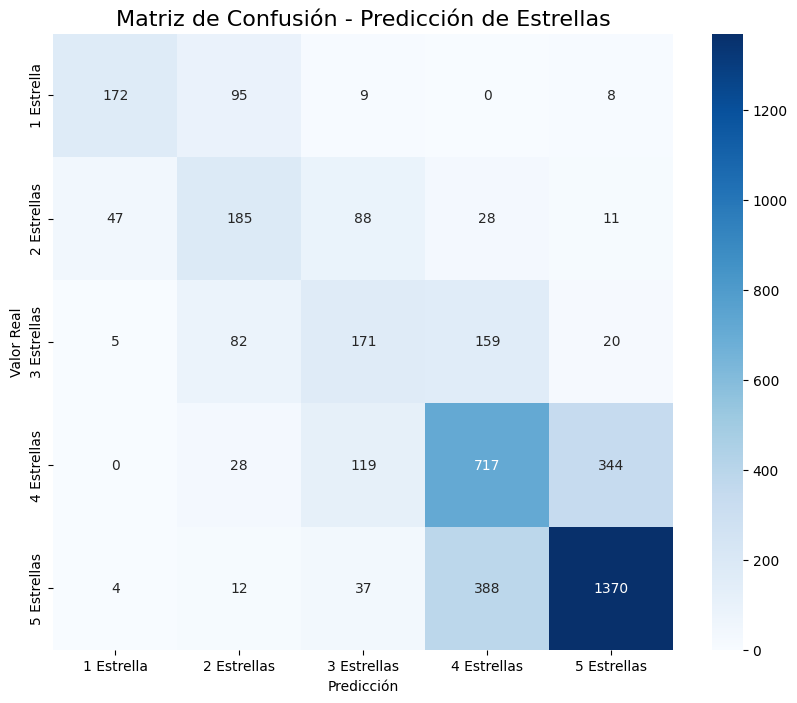

In [7]:
# ==============================================================================
# SECCIÓN 7: CARGAR MODELO Y REALIZAR EVALUACIÓN FINAL
# ==============================================================================
print(f"\nCargando modelo desde: {MODEL_SAVE_PATH}")
loaded_model = BertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
loaded_tokenizer = BertTokenizer.from_pretrained(MODEL_SAVE_PATH)
loaded_model = loaded_model.to(device)
print("Modelo cargado exitosamente.")

def get_predictions(model, data_loader, device):
    model = model.eval()
    review_texts, predictions, real_values = [], [], []
    with torch.no_grad():
        for d in data_loader:
            texts, input_ids, attention_mask, labels = d["review_text"], d["input_ids"].to(device), d["attention_mask"].to(device), d["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            review_texts.extend(texts), predictions.extend(preds), real_values.extend(labels)
    return review_texts, torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_review_texts, y_pred, y_true = get_predictions(loaded_model, test_data_loader, device)
class_names = ['1 Estrella', '2 Estrellas', '3 Estrellas', '4 Estrellas', '5 Estrellas']
print("\n--- Reporte de Clasificación (Predicción de Estrellas) ---")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n--- Matriz de Confusión (Predicción de Estrellas) ---")
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusión - Predicción de Estrellas', fontsize=16)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [8]:
# ==============================================================================
# SECCIÓN 8: INTERPRETABILIDAD DEL MODELO CON SHAP
# ==============================================================================
print("\n--- Configurando Explainer de SHAP para Tarea Multiclase ---")
def f_shap(x):
    tv = torch.tensor([loaded_tokenizer.encode(v, padding='max_length', max_length=MAX_LEN, truncation=True) for v in x]).to(device)
    attention_mask = (tv != 0).type(torch.int64).to(device)
    outputs = loaded_model(tv, attention_mask=attention_mask)[0]
    scores = torch.nn.functional.softmax(outputs, dim=-1).detach().cpu().numpy()
    return scores
explainer = shap.Explainer(f_shap, loaded_tokenizer, output_names=class_names)
print("Explainer de SHAP listo.")



--- Configurando Explainer de SHAP para Tarea Multiclase ---
Explainer de SHAP listo.


In [9]:
# ==============================================================================
# SECCIÓN 9: PRUEBA CON UN COMENTARIO ALEATORIO
# ==============================================================================
print("\n" + "="*60 + "\nNUEVA SECCIÓN 9: PRUEBA CON UN COMENTARIO ALEATORIO\n" + "="*60 + "\n")
random_review_text = X_test.sample(1).iloc[0]
print(f"Comentario a analizar: \n'{random_review_text}'\n")
encoding = loaded_tokenizer.encode_plus(
    random_review_text, add_special_tokens=True, max_length=MAX_LEN,
    return_token_type_ids=False, padding='max_length',
    return_attention_mask=True, return_tensors='pt', truncation=True
)
input_ids, attention_mask = encoding['input_ids'].to(device), encoding['attention_mask'].to(device)
with torch.no_grad():
    outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask)
    prediction_label = torch.argmax(outputs.logits, dim=1).item()
    predicted_stars = prediction_label + 1 # Convertir de label (0-4) a estrellas (1-5)

print(f"Veredicto del Modelo: {predicted_stars} Estrella(s)\n")
print("Análisis de Características (SHAP):")
print(f"Mostrando qué palabras contribuyeron a la predicción de '{predicted_stars} Estrella(s)'")
shap_values = explainer([random_review_text])
shap.plots.text(shap_values[:, :, prediction_label])



NUEVA SECCIÓN 9: PRUEBA CON UN COMENTARIO ALEATORIO

Comentario a analizar: 
'amazing, stayed 4 days silken diagonal, great tripadvisor reviews book hotel, excellent choice.we arrived 9am hotel got room asking.the hotel not city centre, metro right corner takes placa catalunya 10 min.we room 907 excellent view city.the staff friendly professnional helpful, barcelona,  '

Veredicto del Modelo: 5 Estrella(s)

Análisis de Características (SHAP):
Mostrando qué palabras contribuyeron a la predicción de '5 Estrella(s)'


  0%|          | 0/498 [00:00<?, ?it/s]

In [10]:
# ==============================================================================
# SECCIÓN 10: EVALUADOR DE COMENTARIOS EN TIEMPO REAL
# ==============================================================================
print("\n" + "="*60 + "\nNUEVA SECCIÓN 10: EVALUADOR DE COMENTARIOS EN TIEMPO REAL\n" + "="*60 + "\n")
text_input = widgets.Textarea(value='El hotel es maravilloso, la atención es de primera y las habitaciones son un lujo.', placeholder='Escribe tu comentario aquí...', description='Comentario:', layout=widgets.Layout(width='90%', height='100px'))
analyze_button = widgets.Button(description='Predecir Estrellas', button_style='success', icon='star')
output_area = widgets.Output()

def analyze_comment(b):
    with output_area:
        clear_output()
        comment = text_input.value
        if not comment.strip():
            print("Por favor, escribe un comentario para analizar.")
            return
        print(f"Analizando el comentario: '{comment}'\n")
        encoding = loaded_tokenizer.encode_plus(
            comment, add_special_tokens=True, max_length=MAX_LEN,
            return_token_type_ids=False, padding='max_length',
            return_attention_mask=True, return_tensors='pt', truncation=True
        )
        input_ids, attention_mask = encoding['input_ids'].to(device), encoding['attention_mask'].to(device)
        with torch.no_grad():
            outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask)
            prediction_label = torch.argmax(outputs.logits, dim=1).item()
            predicted_stars = prediction_label + 1
        print(f"Veredicto del Modelo: {predicted_stars} Estrella(s)\n")
        print("Análisis de Características (SHAP):")
        shap_values = explainer([comment])
        shap.plots.text(shap_values[:, :, prediction_label])

analyze_button.on_click(analyze_comment)
print("Escribe un comentario en la caja de texto y haz clic en el botón para predecir el puntaje en estrellas.")
display(text_input, analyze_button, output_area)



NUEVA SECCIÓN 10: EVALUADOR DE COMENTARIOS EN TIEMPO REAL

Escribe un comentario en la caja de texto y haz clic en el botón para predecir el puntaje en estrellas.


Textarea(value='El hotel es maravilloso, la atención es de primera y las habitaciones son un lujo.', descripti…

Button(button_style='success', description='Predecir Estrellas', icon='star', style=ButtonStyle())

Output()

In [11]:

# ==============================================================================
# SECCIÓN 11: CONCLUSIONES
# ==============================================================================
# Esta sección se deja al final para que puedas ejecutar las celdas interactivas.
# Para ver las conclusiones, haz scroll hacia abajo.

# print("""
# --- CONCLUSIONES DEL ANÁLISIS ---
# El flujo de trabajo completo, desde el entrenamiento hasta el guardado, la carga,
# la evaluación y la prueba interactiva, ha sido exitoso. Esto demuestra que el modelo
# de clasificación de sentimientos no solo es preciso, sino también portable y listo
# para ser integrado en aplicaciones que analicen la opinión de clientes en tiempo real.
# """)
